In [1]:
from functools import lru_cache

import chromadb
import ir_datasets
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from ir_measures import ScoredDoc, calc_aggregate, nDCG
from sentence_transformers import SentenceTransformer
from tqdm import tqdm

from utils import persistent_cache

dataset = ir_datasets.load("beir/nfcorpus")
model = SentenceTransformer("Qwen/Qwen3-Embedding-0.6B")
chroma_client = chromadb.Client()

# chroma_client.delete_collection(name="beir_nfcorpus_documents")
# chroma_client.delete_collection(name="beir_nfcorpus_queries")


EMBEDDINGS_CACHE = "./.cache/embeddings/"
EMBED_DIM = 1024


/home/yashasvi/miniconda3/envs/matryoshka-analysis/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Generate and cache the full embeddings first.

In [2]:
@persistent_cache.persistent_cache(
    directory=EMBEDDINGS_CACHE, hash_filenames=True, file_type="json"
)
def calculate_embeddings(text):
    embeddings = model.encode(text)
    embeddings = embeddings.tolist()
    return {"embeddings": embeddings}


@lru_cache(maxsize=7000)
def fetch_embeddings(text):
    embeddings = calculate_embeddings(text)
    return embeddings


def create_collection(chroma_client):
    chroma_collection_documents = chroma_client.get_or_create_collection(
        name="beir_nfcorpus_documents", metadata={"hnsw:space": "cosine"}
    )
    return chroma_collection_documents

In [3]:
def index_docs(chroma_collection_documents, retain_dim):
    for doc in dataset.docs_iter():
        doc_text = doc.title + " " + doc.text
        doc_emb = fetch_embeddings(doc_text)["embeddings"][:retain_dim]
        chroma_collection_documents.add(
            documents=[doc_text],
            embeddings=[doc_emb],
            metadatas=[{"url": doc.url, "id": doc.doc_id}],
            ids=[doc.doc_id],
        )


def cache_all_queries(retain_dim):
    SEARCH_PROMPT_PREFIX = "Instruct: Given a web search query, retrieve relevant passages that answer the query\nQuery:"

    for query in dataset.queries_iter():
        query_text = SEARCH_PROMPT_PREFIX + " " + query.text
        query_embed = calculate_embeddings(query_text)["embeddings"][:retain_dim]

Now that all the documents and queries has been embedded. Lets create a baseline that we can test over

In [4]:
def fetch_query_embeddings(query):
    query_embeddings = calculate_embeddings(query)["embeddings"]
    return query_embeddings


def search(chroma_collection_documents, query_id, query_embeddings):
    search_resp = chroma_collection_documents.query(query_embeddings=[query_embeddings])
    # return search_resp["ids"][0]
    # return search_resp

    result = []
    for hit_index in range(len(search_resp["ids"][0])):
        # convert norm dist to similarity
        similarity = 1 - search_resp["distances"][0][hit_index]
        result.append(ScoredDoc(query_id, search_resp["ids"][0][hit_index], similarity))
    return result


In [5]:
def delete_collection(chroma_client):
    try:
        chroma_client.delete_collection("beir_nfcorpus_documents")
    except Exception as e:
        print("collection doesnt exist")


delete_collection(chroma_client)

collection doesnt exist


In [7]:
test_dataset = ir_datasets.load("beir/nfcorpus/test")


@persistent_cache.persistent_cache(
    directory="./.cache/analysis/", hash_filenames=True, file_type="json"
)
def analyse_for_dimention(dimention):
    run_results = []
    metrics = [nDCG @ 10]

    delete_collection(chroma_client)
    chroma_collection_documents = create_collection(chroma_client)
    index_docs(chroma_collection_documents, retain_dim=dimention)

    for query in test_dataset.queries_iter():
        qid = query.query_id
        query_text = query.text
        query_embeddings = fetch_query_embeddings(query_text)[:dimention]
        run_results.extend(search(chroma_collection_documents, qid, query_embeddings))

    metrics = calc_aggregate(metrics, test_dataset.qrels, run_results)

    return {"dimention": dimention, "nDCG@10": metrics[nDCG @ 10]}


analyse_for_dimention(1024)


{'dimention': 1024, 'nDCG@10': 0.2970801488908999}

In [8]:
results = []
START_DIM = 1
END_DIM = 1024 + 1
for dim in tqdm(
    range(START_DIM, END_DIM),
    total=END_DIM - START_DIM,
    desc="Running with DIM",
):
    run_results = analyse_for_dimention(dim)
    results.append(run_results)


# print("Ranking metric NDCG@10 {:.4f}".format(metrics[nDCG @ 10]))

Running with DIM: 100%|██████████| 1024/1024 [00:00<00:00, 6015.87it/s]


In [9]:
df = pd.DataFrame(results)
# df.to_csv("./files/results.csv")
df.head()

,dimention,nDCG@10
0,1,0.008254
1,2,0.011227
2,3,0.010836
3,4,0.013483
4,5,0.015079


In [10]:
def fetch_score_for_dim(dim, df=df):
    return df[df["dimention"] == dim].iloc[0]["nDCG@10"]


fetch_score_for_dim(10)

np.float64(0.028556835884210513)

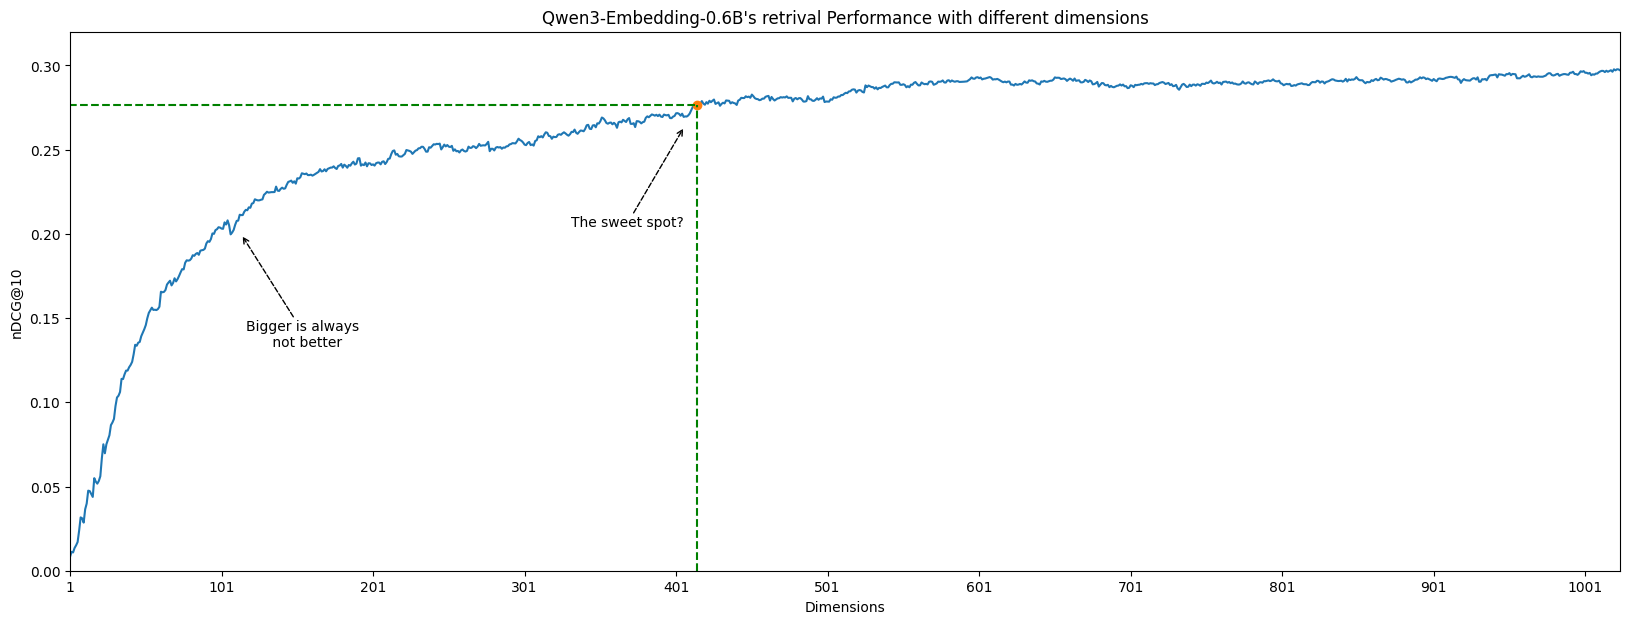

In [11]:
x = df["dimention"]
y = df["nDCG@10"]

annotate_dim = 415
annoatate_y = fetch_score_for_dim(annotate_dim)

fig, ax = plt.subplots(figsize=(20, 7))
(line,) = ax.plot(x, y)
_ = plt.title("Qwen3-Embedding-0.6B's retrival Performance with different dimensions")
_ = plt.xticks(np.arange(min(x), max(x) + 1, 100.0))
_ = ax.plot([annotate_dim], [annoatate_y], "o")
_ = plt.xlim(1, 1024)
_ = plt.ylim(0, 0.32)
_ = plt.xlabel("Dimensions")
_ = plt.ylabel("nDCG@10")

_ = ax.annotate(
    "The sweet spot?",
    xy=(annotate_dim, annoatate_y),
    xycoords="data",
    xytext=(-50, -90),
    textcoords="offset points",
    arrowprops=dict(
        arrowstyle="->", facecolor="black", shrinkA=0, shrinkB=20, ls="dashed"
    ),
    horizontalalignment="center",
    verticalalignment="bottom",
    clip_on=True,
)

_ = ax.annotate(
    "Bigger is always \n not better",
    xy=(110, fetch_score_for_dim(110)),
    xycoords="data",
    xytext=(50, -90),
    textcoords="offset points",
    arrowprops=dict(
        arrowstyle="->", facecolor="black", shrinkA=0, shrinkB=10, ls="dashed"
    ),
    horizontalalignment="center",
    verticalalignment="bottom",
    clip_on=True,
)


_ = ax.hlines(
    y=annoatate_y,
    xmin=0,
    xmax=annotate_dim,
    clip_on=True,
    color="Green",
    linestyle="--",
)
_ = ax.vlines(
    x=annotate_dim,
    ymin=0,
    ymax=annoatate_y,
    clip_on=True,
    color="Green",
    linestyle="--",
)

plt.savefig("./files/result.png")
plt.show()
